# Time-Series prediction with LSTM

## 1. Import Libraries

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cftime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Load Data

In [2]:
# 1. Load the dataset
file_path = '003_2006_2080_352_360.nc'
ds = xr.open_dataset(file_path)

In [3]:
# 2. Extract TREFMXAV_U data for Manchester
# Approximate coordinates of Manchester: Latitude 53.4808, Longitude -2.2426
# Use the 'nearest' method to select the closest grid point
manchester_data = ds['TREFMXAV_U'].sel(lat=53.4808, lon=-2.2426, method="nearest")

In [4]:
# 3. Convert data to a pandas DataFrame and ensure time is in datetime format
df = manchester_data.to_dataframe().reset_index()
print(type(df['time'].iloc[0]))
df['time'] = df['time'].apply(lambda x: pd.Timestamp(x.isoformat()) if isinstance(x, cftime.DatetimeNoLeap) else x)
df = df.sort_values('time')

<class 'cftime._cftime.DatetimeNoLeap'>


## 3. Data overview

In [ ]:

print("Dataset Overview:")
print(df.info())  # General information
print("\nStatistical Summary:")
print(df.describe())  # Summary statistics
print("\nMissing Values:")
print(df.isnull().sum())  # Check for missing values
print("\nTime Range:")
print(f"Start Date: {df['time'].min()}")
print(f"End Date: {df['time'].max()}")

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27374 entries, 0 to 27373
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        27374 non-null  datetime64[ns]
 1   lat         27374 non-null  float32       
 2   lon         27374 non-null  float32       
 3   TREFMXAV_U  27374 non-null  float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 534.8 KB
None

Statistical Summary:
                                time           lat           lon    TREFMXAV_U
count                          27374  27374.000000  27374.000000  27374.000000
mean   2043-07-02 19:59:07.395338240     53.246078    352.500000    288.762726
min              2006-01-02 00:00:00     53.246075    352.500000    274.354095
25%              2024-10-02 06:00:00     53.246075    352.500000    285.026932
50%              2043-07-02 12:00:00     53.246075    352.500000    288.269623
75%              2062-04

## 4. Data Transformations

In [6]:
# 4. Split data into training and testing sets
# Training set: 2006-01-01 to 2049-12-31
# Testing set: 2050-01-01 to 2080-12-31
train_df = df[(df['time'] >= '2006-01-01') & (df['time'] < '2050-01-01')]
test_df = df[(df['time'] >= '2050-01-01') & (df['time'] <= '2080-12-31')]

In [7]:
# 5. Extract target variable and reshape it
# Assuming TREFMXAV_U is the value to be predicted
train_values = train_df['TREFMXAV_U'].values.reshape(-1, 1)
test_values = test_df['TREFMXAV_U'].values.reshape(-1, 1)

In [8]:
# 6. Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

In [9]:
# 7. Create sequences for time series data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 3  # Use past 30 days to predict the next day
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [10]:
# 8. Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
# 9. Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
452/452 [==============================] - 3s 4ms/step - loss: 0.0167 - val_loss: 0.0041
Epoch 2/20
452/452 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 3/20
452/452 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 4/20
452/452 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 5/20
452/452 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/20
452/452 [==============================] - 1s 3ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 7/20
452/452 [==============================] - 1s 3ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 8/20
452/452 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/20
452/452 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/20
452/452 [==============================] - 1s 3ms/step - loss: 0.0035 - val_loss: 0.0033

## 5. Model Deployment

The section contains a script that generates predictions using the trained LSTM model and applies inverse scaling to restore them to their original values. It then evaluates the model's performance using metrics such as MAE, MSE, RMSE, R² score, and MAPE before visualizing the actual versus predicted values in a time-series plot.

354/354 [==============================] - 0s 1ms/step
Evaluation Metrics:
MAE: 1.554
MSE: 3.959
RMSE: 1.990
R2 Score: 0.853
MAPE: 0.54%


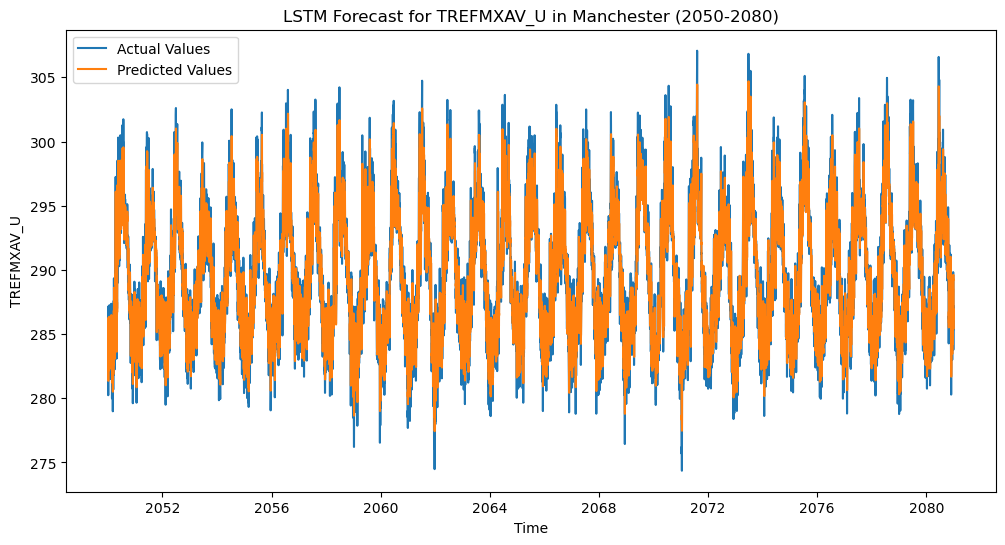

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 10. Make predictions on the test set
predicted = model.predict(X_test)
predicted_inverse = scaler.inverse_transform(predicted)

true_values = test_values[seq_length:]

mae = mean_absolute_error(true_values, predicted_inverse)
mse = mean_squared_error(true_values, predicted_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predicted_inverse)
mape = np.mean(np.abs((true_values - predicted_inverse) / true_values)) * 100

print("Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")

# 11. Plot the prediction results
plt.figure(figsize=(12, 6))
plt.plot(test_df['time'].values[seq_length:], true_values, label='Actual Values')
plt.plot(test_df['time'].values[seq_length:], predicted_inverse, label='Predicted Values')
plt.title("LSTM Forecast for TREFMXAV_U in Manchester (2050-2080)")
plt.xlabel("Time")
plt.ylabel("TREFMXAV_U")
plt.legend()
plt.show()


In [11]:
complex_model = Sequential()

complex_model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
complex_model.add(Dropout(0.2))

complex_model.add(LSTM(32, activation='relu', return_sequences=False))
complex_model.add(Dropout(0.2))

complex_model.add(Dense(32, activation='relu'))
complex_model.add(Dense(16, activation='relu'))

complex_model.add(Dense(1)) 

optimizer = Adam(learning_rate=0.001)
complex_model.compile(optimizer=optimizer, loss='mse')

complex_model.summary()

history_complex = complex_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 3, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                

## 6. Model Evaluation

354/354 [==============================] - 3s 4ms/step
Evaluation Metrics:
MAE: 1.695
MSE: 4.620
RMSE: 2.150
R2 Score: 0.828
MAPE: 0.58%


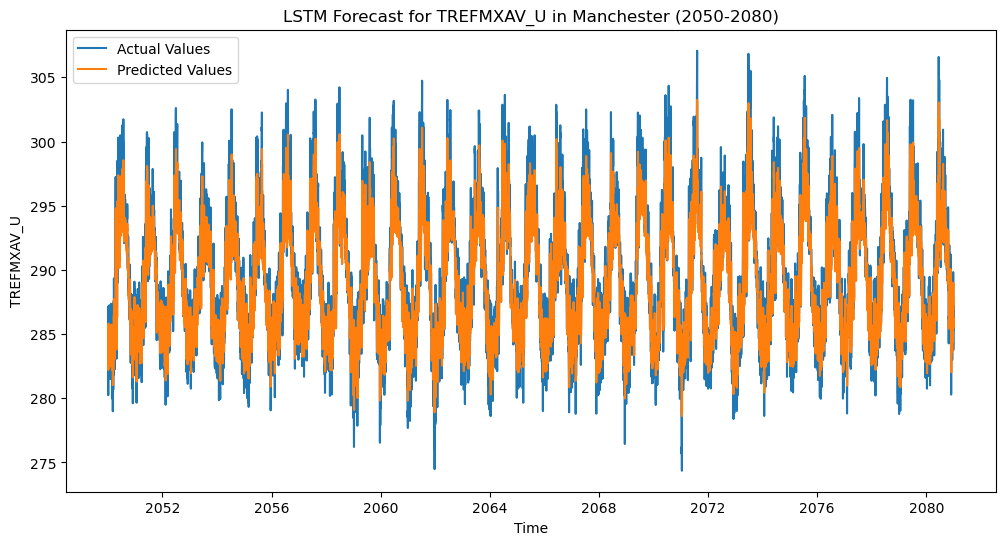

In [ ]:

# Make predictions on the test set
predicted = complex_model.predict(X_test)
predicted_inverse = scaler.inverse_transform(predicted)

true_values = test_values[seq_length:]

mae = mean_absolute_error(true_values, predicted_inverse)
mse = mean_squared_error(true_values, predicted_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predicted_inverse)
mape = np.mean(np.abs((true_values - predicted_inverse) / true_values)) * 100

print("Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")

# 11. Plot the prediction results
plt.figure(figsize=(12, 6))
plt.plot(test_df['time'].values[seq_length:], true_values, label='Actual Values')
plt.plot(test_df['time'].values[seq_length:], predicted_inverse, label='Predicted Values')
plt.title("LSTM Forecast for TREFMXAV_U in Manchester (2050-2080)")
plt.xlabel("Time")
plt.ylabel("TREFMXAV_U")
plt.legend()
plt.show()

In [16]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []
